# Choosing Lens Galaxies from CosmoDC2 galaxies in the DDF Region

Author: Bryce Kalmbach ([@jbkalmbach](https://github.com/jbkalmbach))

Last Updated: 4/1/20

In this notebook we are choosing galaxies that are present in the CosmoDC2 catalog of the DDF region to be lens galaxies as we sprinkle in strongly lensed systems. The choice of which galaxies to use will require matching DDF galaxies to lens galaxies in the systems from the [Oguri and Marshall 2010 catalog](https://github.com/drphilmarshall/OM10) (for strongly lensed AGN) and the [Goldstein et al 2019 catalog](https://arxiv.org/abs/1809.10147) (for strongly lensed SNe). 

We then perform a second matching to get the host galaxies for the systems chosen to be added into the DDF. The host galaxies from the lensing catalogs are matched to cosmoDC2 galaxies from well outside the DDF and the properties of the lens systems are then recalculated to get correct time delays and image properties.

In [8]:
import os
import GCRCatalogs
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from sqlalchemy import create_engine
from GCR import GCRQuery

## Load CosmoDC2 Data in DDF region with GCR

Our first step is to load in all the cosmoDC2 galaxies from the DDF with `GCRCatalogs`

In [2]:
catalog_version = 'cosmoDC2_v1.1.4'

In [3]:
catalog = GCRCatalogs.load_catalog(str(catalog_version + '_image_addon_knots'))

In [4]:
quantity_list = ['galaxy_id',
                 'ra',
                 'dec',
                 'redshift_true',
                 'shear_1',
                 'shear_2_phosim',
                 'convergence',
                 'position_angle_true',
                 'size_true',
                 'size_minor_true',
                 'size_disk_true',
                 'size_minor_disk_true',
                 'size_bulge_true',
                 'size_minor_bulge_true',
                 'ellipticity',
                 'sersic_disk',
                 'sersic_bulge',
                 'stellar_mass_disk',
                 'stellar_mass_bulge',
                 'stellar_mass',
                 'totalStarFormationRate',
                 'Mag_true_u_lsst_z0',
                 'Mag_true_r_lsst_z0',
                 'morphology/spheroidHalfLightRadius', 
                 'morphology/spheroidHalfLightRadiusArcsec',
                 'mag_true_r_lsst',
                ]

We first pick a set of potential lens galaxies within the DDF. Here we just grab all the galaxies from the DDF. In subsequent steps we will narrow this down to galaxies that are large elliptical galaxies. We are going to relate these to the lens catalogs using the velocity dispersion and redshift to match to similar systems.

In [8]:
dc2_all_lens_gals = catalog.get_quantities(quantity_list, filters=['ra < 53.755', 'ra > 52.495',
                                                                      'dec < -27.55', 'dec > -28.65'])

In [12]:
### To save:
# with open('%s/ddf_all_lens_gals.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(dc2_all_lens_gals, f)
    
### To load:
# with open('%s/ddf_all_lens_gals.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     dc2_all_lens_gals = pickle.load(f)

We also pick a set of potential host galaxies from the opposite corner of the CosmoDC2 field from the DDF. We are going to use these galaxies to match to the lensing systems and use some of their properties when we add in lensed host galaxies to the DDF.

In [6]:
dc2_all_host_gals = catalog.get_quantities(quantity_list, filters=['ra < 75.', 'ra > 72.5',
                                                                            'dec < -42.5', 'dec > -45.',
                                                                            'redshift_true > 0.25'])

In [5]:
### To save:
# with open('%s/ddf_all_host_gals.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(dc2_all_host_gals, f)
    
## To load:
# with open('%s/ddf_all_host_gals.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     dc2_all_host_gals = pickle.load(f)

## Match Host galaxies to AGN-hosting CosmoDC2 galaxies from outside the DDF

For the host galaxies we want to add in the AGN properties to those that host AGN since we want lensed AGN and lensed SNe. To do this we load the AGN database and match on `galaxy_id`.

In [6]:
import sqlite3

In [7]:
agn_db_file = '/global/cscratch1/sd/jchiang8/desc/sims_GCRCatSimInterface/work/2020-02-14/agn_cosmoDC2_v1.1.4.db'

In [8]:
conn = sqlite3.connect(agn_db_file)
cur = conn.cursor()

In [9]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('agn_params',)]


In [10]:
agn_df = pd.read_sql_query("SELECT * from agn_params", conn)

In [11]:
agn_df.head()

,galaxy_id,htmid_8,magNorm,redshift,M_i,ra,dec,varParamStr
0,1250000080,147070,24.532759,0.045305,-12.570935,50.823681,-27.152892,"{""m"": ""applyAgn"", ""p"": {""seed"": 4353780, ""agn_..."
1,1250001927,147054,24.977323,0.088624,-13.584557,51.722197,-25.667408,"{""m"": ""applyAgn"", ""p"": {""seed"": 9678465, ""agn_..."
2,1250004840,147060,24.596580,0.115142,-14.631356,49.778938,-25.982403,"{""m"": ""applyAgn"", ""p"": {""seed"": 7595204, ""agn_..."
3,1250005239,147047,23.916831,0.113542,-15.264852,50.901542,-25.769011,"{""m"": ""applyAgn"", ""p"": {""seed"": 7102854, ""agn_..."
4,1250009839,145048,23.638732,0.146706,-16.036147,50.356496,-25.032873,"{""m"": ""applyAgn"", ""p"": {""seed"": 3578619, ""agn_..."


In [12]:
len(agn_df)

4221027

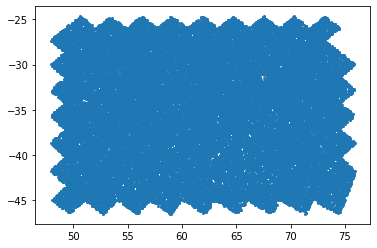

In [13]:
plt.scatter(agn_df['ra'][::100], agn_df['dec'][::100], s=4)

In [14]:
agn_df_cut = agn_df.query('ra > 72.5 and ra < 75. and dec > -45 and dec < -42.5 and redshift > 0.25')

Check how many AGN the region we've selected will give us as potential lensed hosts.

In [15]:
len(agn_df_cut)

43086

43k should be enough. We want to end up with ~1000 in our DDF sample.

### Get healpix ids

We will need these to open the correct SED files.

In [16]:
import healpy
def get_healpix_id(ra, dec):
    pix_id = healpy.ang2pix(32, ra, dec, nest=False, lonlat=True)
    return pix_id

In [25]:
len(dc2_all_lens_gals['ra'])

6194586

In [26]:
healpix_ids_lenses = get_healpix_id(dc2_all_lens_gals['ra'], dc2_all_lens_gals['dec'])

In [27]:
healpix_ids_lenses

array([8914, 8914, 8914, ..., 9043, 9043, 9043])

In [17]:
healpix_ids_hosts = get_healpix_id(dc2_all_host_gals['ra'], 
                                   dc2_all_host_gals['dec'])

In [18]:
healpix_ids_hosts

array([10201, 10201, 10201, ..., 10452, 10452, 10452])

### Put galaxy information into pandas dataframe

In [33]:
lens_gal_df = pd.DataFrame(dc2_all_lens_gals)

In [34]:
lens_gal_df.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,stellar_mass,galaxy_id,dec,ra,redshift_true,sersic_bulge,position_angle_true,morphology/spheroidHalfLightRadius,stellar_mass_disk,size_bulge_true
0,0.692787,0.654324,1.390374,0.000000,7396574.0,19.664267,1.0,-13.647583,-0.000000,0.733156,...,1.253216e+07,1875000009,-27.950583,52.545849,0.020617,4.0,3.872094,0.288956,5.135591e+06,0.692787
1,0.739462,0.674218,1.494187,0.000000,1097576.5,19.639227,1.0,-13.789320,-0.000000,0.670891,...,7.947000e+06,1875000034,-27.692493,52.623324,0.019394,4.0,151.776670,0.287348,6.849424e+06,0.739462
2,0.913097,0.896222,2.377272,0.000000,0.0,21.385635,1.0,-11.321993,-0.000000,0.970572,...,1.003473e+06,1875000035,-27.857692,52.681314,0.017482,4.0,50.902277,0.326662,1.003473e+06,0.913097
3,1.537620,1.532605,3.411983,0.000000,9869368.0,18.350533,1.0,-14.870754,-0.000000,3.347761,...,4.906946e+07,1875000055,-27.599111,52.581461,0.017347,4.0,174.550510,0.533548,3.920008e+07,1.537620
4,0.602592,0.566917,1.470491,-0.000014,1162219.0,21.644880,1.0,-13.690415,-0.000026,1.000541,...,8.671905e+06,1875000072,-27.665230,52.737179,0.046867,4.0,117.095584,0.526612,7.509686e+06,0.602592


In [35]:
lens_gal_df['healpix_id'] = healpix_ids_lenses

In [19]:
host_gal_df = pd.DataFrame(dc2_all_host_gals)

In [20]:
host_gal_df.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,stellar_mass,galaxy_id,dec,ra,redshift_true,sersic_bulge,position_angle_true,morphology/spheroidHalfLightRadius,stellar_mass_disk,size_bulge_true
0,1.012711,0.916337,1.545864,-0.002380,1.510516e+10,19.147808,1.0,-20.187057,0.002234,1.293610,...,3.848801e+10,10687557194,-42.627026,72.607130,0.25686,4.0,28.787977,4.074877,2.338286e+10,1.012711
1,0.153582,0.152041,0.271755,-0.002250,0.000000e+00,23.047113,1.0,-16.430550,0.002033,0.223761,...,2.003216e+08,10687557195,-42.616384,72.613209,0.25686,4.0,135.359014,0.618968,2.003216e+08,0.153582
2,0.261468,0.254134,0.567076,-0.002471,0.000000e+00,22.363756,1.0,-16.778028,0.002438,0.393428,...,4.675741e+08,10687557196,-42.630891,72.597708,0.25686,4.0,179.613169,1.053164,4.675741e+08,0.261468
3,0.084224,0.083505,0.167496,-0.002250,0.000000e+00,25.148592,1.0,-14.277241,0.002095,0.115785,...,1.600792e+07,10687557197,-42.618750,72.608670,0.25686,4.0,109.102593,0.339482,1.600792e+07,0.084224
4,0.316920,0.315717,0.652051,-0.002246,0.000000e+00,22.020205,1.0,-17.378386,0.002234,0.637959,...,7.094749e+08,10687557198,-42.621983,72.596165,0.25686,4.0,145.525863,1.271877,7.094749e+08,0.316920


In [21]:
host_gal_df['healpix_id'] = healpix_ids_hosts

In [22]:
np.unique(healpix_ids_hosts, return_counts=True)

(array([10201, 10202, 10328, 10329, 10452, 10572]),
 array([  794648,   978249,    42432, 13804046,  7343597,       19]))

To make SED loading quicker (we have to load an entire healpixel worth of SED info at a time as we will show below) we will only take the four healpixels with the most galaxies.

In [23]:
host_gal_df = host_gal_df.query('healpix_id < 10203 or healpix_id == 10329 or healpix_id == 10452').reset_index(drop=True)

### Join host bulge/disk and agn databases on `galaxy_id`

In [24]:
host_gal_full = host_gal_df.join(agn_df.set_index('galaxy_id'), on='galaxy_id', rsuffix='_agn')

In [25]:
host_gal_full = host_gal_full.rename(columns={'magNorm':'magNorm_agn', 
                                              'varParamStr':'varParamStr_agn',
                                              'redshift':'redshift_agn'})

In [26]:
agn_host_gal_full = host_gal_full.query('ra_agn > -99.').reset_index(drop=True)

In [27]:
agn_host_gal_full.head(2)

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,stellar_mass_disk,size_bulge_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn
0,1.589502,1.522582,3.065912,-0.002185,5.390875e+10,19.558434,1.0,-19.569359,0.001554,3.000389,...,7.155991e+09,1.589502,10201,144291.0,23.752536,0.303496,-17.790545,72.57645,-42.536578,"{""m"": ""applyAgn"", ""p"": {""seed"": 6324137, ""agn_..."
1,0.868923,0.753715,1.622119,-0.002304,1.940904e+10,19.813519,1.0,-19.766169,0.002076,0.972919,...,8.473058e+09,0.868923,10201,144291.0,24.761045,0.303507,-16.782145,72.57532,-42.533373,"{""m"": ""applyAgn"", ""p"": {""seed"": 7181317, ""agn_..."


In [28]:
len(agn_host_gal_full)

43010

Good, we still have ~43000 systems even after dropping 2 healpixels.

In [29]:
sne_host_gal_full = host_gal_full.iloc[np.where(np.isnan(host_gal_full['M_i'].values))]

In [31]:
len(sne_host_gal_full)

22877530

We don't really need this many. We just want a sample big enough to match to ~1000 host galaxies from the Goldstein et al. catalog. Let's only keep 1/100 to speed things up.

In [32]:
sne_host_gal_full = sne_host_gal_full.iloc[::100]

In [33]:
len(sne_host_gal_full)

228776

In [34]:
sne_host_gal_full = sne_host_gal_full.reset_index(drop=True)

In [35]:
sne_host_gal_full.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,stellar_mass_disk,size_bulge_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn
0,1.012711,0.916337,1.545864,-0.002380,1.510516e+10,19.147808,1.0,-20.187057,0.002234,1.293610,...,2.338286e+10,1.012711,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.094638,0.092058,0.222752,-0.002071,0.000000e+00,26.182716,1.0,-12.955414,0.000236,0.176510,...,2.300287e+06,0.094638,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.103148,0.099730,0.220794,-0.002114,2.646877e+06,25.285751,1.0,-14.015959,-0.000444,0.142253,...,9.339962e+06,0.103148,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.119716,0.117719,0.257690,-0.002283,2.805823e+06,24.756550,1.0,-14.614126,0.001647,0.231094,...,1.493341e+07,0.119716,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.091120,0.080544,0.204694,-0.001325,0.000000e+00,25.898499,1.0,-13.266086,0.000570,0.040981,...,3.180387e+06,0.091120,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate i-band mags for AGN

In [36]:
from lsst.sims.photUtils import Sed, BandpassDict, getImsimFluxNorm, Bandpass
from lsst.utils import getPackageDir
from copy import deepcopy
import os

In [37]:
lsst_bp_dict = BandpassDict.loadTotalBandpassesFromFiles()

In [38]:
os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED'))

['agn.spec.gz']

In [39]:
agn_sed = Sed()
agn_sed.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED', 'agn.spec.gz'))

In [40]:
mag_i_agn = []
for agn_data in agn_host_gal_full[['magNorm_agn', 'redshift_true']].values:
    agn_mag, agn_redshift = agn_data
    if np.isnan(agn_mag):
        mag_i_agn.append(np.nan)
        continue
    agn_copy = deepcopy(agn_sed)
    flux_norm = getImsimFluxNorm(agn_copy, agn_mag)
    agn_copy.multiplyFluxNorm(flux_norm)
    agn_copy.redshiftSED(agn_redshift, dimming=True)
    mag_i_agn.append(agn_copy.calcMag(lsst_bp_dict['i']))

In [41]:
agn_host_gal_full['mag_i_agn'] = mag_i_agn

In [42]:
agn_host_gal_full.head(10)

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,size_bulge_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn,mag_i_agn
0,1.589502,1.522582,3.065912,-0.002185,5.390875e+10,19.558434,1.0,-19.569359,0.001554,3.000389,...,1.589502,10201,144291.0,23.752536,0.303496,-17.790545,72.576450,-42.536578,"{""m"": ""applyAgn"", ""p"": {""seed"": 6324137, ""agn_...",23.577279
1,0.868923,0.753715,1.622119,-0.002304,1.940904e+10,19.813519,1.0,-19.766169,0.002076,0.972919,...,0.868923,10201,144291.0,24.761045,0.303507,-16.782145,72.575320,-42.533373,"{""m"": ""applyAgn"", ""p"": {""seed"": 7181317, ""agn_...",24.585786
2,0.804792,0.765873,1.180318,-0.004736,7.096259e+10,19.778311,1.0,-19.780472,0.001669,0.870226,...,0.804792,10201,144288.0,24.726687,0.348136,-17.071811,72.589333,-43.114100,"{""m"": ""applyAgn"", ""p"": {""seed"": 2221308, ""agn_...",24.558383
3,0.295911,0.268692,0.445892,-0.004484,7.515603e+09,20.780214,1.0,-19.309547,0.000417,0.293846,...,0.295911,10201,144291.0,26.666270,0.364838,-15.265509,72.571873,-42.702451,"{""m"": ""applyAgn"", ""p"": {""seed"": 5286209, ""agn_...",26.500103
4,0.822198,0.572032,1.709685,-0.004660,2.806170e+10,21.270239,1.0,-19.231823,0.001598,0.546584,...,0.822198,10201,144291.0,25.008189,0.446487,-17.341452,72.854422,-42.511687,"{""m"": ""applyAgn"", ""p"": {""seed"": 7166592, ""agn_...",24.790650
5,0.317425,0.278152,0.585856,-0.005350,1.106134e+10,21.920746,1.0,-19.050600,0.001106,0.280572,...,0.317425,10201,144288.0,26.563393,0.467317,-15.869930,72.744129,-42.926226,"{""m"": ""applyAgn"", ""p"": {""seed"": 8584799, ""agn_...",26.338894
6,0.295592,0.272661,0.463811,-0.006764,1.140627e+10,21.403263,1.0,-19.445536,-0.000604,0.359278,...,0.295592,10201,144288.0,27.327995,0.463055,-15.053496,72.563920,-42.880291,"{""m"": ""applyAgn"", ""p"": {""seed"": 1275907, ""agn_...",27.104330
7,0.336431,0.210630,0.444014,-0.001769,1.440132e+10,20.983217,1.0,-20.480183,0.004183,0.132741,...,0.336431,10201,144291.0,26.813883,0.520946,-15.881948,72.584951,-42.589501,"{""m"": ""applyAgn"", ""p"": {""seed"": 4156022, ""agn_...",26.578994
8,0.819994,0.666118,1.166932,-0.001949,1.062921e+11,20.767252,1.0,-20.534754,0.004161,0.557030,...,0.819994,10201,144288.0,24.684347,0.533874,-18.068410,72.627155,-42.985973,"{""m"": ""applyAgn"", ""p"": {""seed"": 5243173, ""agn_...",24.443504
9,0.726081,0.518302,1.115899,-0.001130,7.454884e+10,21.200270,1.0,-20.252264,0.002579,0.288233,...,0.726081,10329,144291.0,24.508712,0.552012,-18.309940,72.882689,-42.545015,"{""m"": ""applyAgn"", ""p"": {""seed"": 307545, ""agn_s...",24.267363


## Load cached SED information for galaxies

We need to load in SEDs for each galaxy. These have been previously assigned and cached but are stored by healpix id.

In [43]:
sed_dir = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup'

In [44]:
import h5py

In [53]:
sed_df = pd.DataFrame([], columns=['bulge_av',
 'bulge_rv',
 'bulge_sed',
 'disk_av',
 'disk_rv',
 'disk_sed',
 'galaxy_id',])

In [54]:
for hpix in np.unique(healpix_ids_lenses):
    f = h5py.File(os.path.join(sed_dir, 'sed_fit_%i.h5' % hpix))
    
    sed_hpix_df = pd.DataFrame([])

    band_list = ['u', 'g', 'r', 'i', 'z', 'y']
    sed_names = f['sed_names'][()]
    for key in list(f.keys()):
        print(key, f[key].len())
        # if (key.endswith('fluxes') or key.endswith('magnorm')):
        if key.endswith('magnorm'):
            key_data = f[key][()]
            for i in range(6):
                sed_hpix_df[str(key + '_' + band_list[i])] = key_data[i]
        elif key in ['sed_names', 'ra', 'dec']:
            continue
        elif key.endswith('fluxes'):
            continue
        elif key.endswith('sed'):
            sed_hpix_df[key] = [sed_names[idx] for idx in f[key][()]]
        else:
            sed_hpix_df[key] = f[key][()]
            
    sed_df = pd.concat([sed_df, sed_hpix_df], sort=False)

bulge_av 17251417
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17251417
bulge_sed 17251417
dec 17251417
disk_av 17251417
disk_fluxes 6
disk_magnorm 6
disk_rv 17251417
disk_sed 17251417
galaxy_id 17251417
ra 17251417
redshift 17251417
sed_names 959
tot_fluxes 6
bulge_av 17215541
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17215541
bulge_sed 17215541
dec 17215541
disk_av 17215541
disk_fluxes 6
disk_magnorm 6
disk_rv 17215541
disk_sed 17215541
galaxy_id 17215541
ra 17215541
redshift 17215541
sed_names 959
tot_fluxes 6
bulge_av 17182059
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17182059
bulge_sed 17182059
dec 17182059
disk_av 17182059
disk_fluxes 6
disk_magnorm 6
disk_rv 17182059
disk_sed 17182059
galaxy_id 17182059
ra 17182059
redshift 17182059
sed_names 959
tot_fluxes 6


In [55]:
sed_df = sed_df.reset_index(drop=True)

In [56]:
sed_df.tail()

,bulge_av,bulge_rv,bulge_sed,disk_av,disk_rv,disk_sed,galaxy_id,bulge_magnorm_u,bulge_magnorm_g,bulge_magnorm_r,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
51649012,0.1,2.0,b'galaxySED/Inst.16E08.1Z.spec.gz',0.1,2.8,b'galaxySED/Inst.10E08.04Z.spec.gz',2583392369,31.630559,30.313428,30.157882,30.176097,30.135977,30.093492,30.664487,30.274829,30.126130,30.117537,30.114116,30.077079,2.998998
51649013,0.1,2.0,b'galaxySED/Inst.20E08.02Z.spec.gz',0.1,2.2,b'galaxySED/Inst.80E07.02Z.spec.gz',2583392370,32.589788,31.523507,31.372035,31.325759,31.233770,31.232998,34.161275,33.793000,33.617714,33.588306,33.563978,33.531616,3.027994
51649014,0.1,2.0,b'galaxySED/Burst.12E09.04Z.spec.gz',0.0,2.0,b'galaxySED/Burst.12E09.04Z.spec.gz',2583392371,31.515505,30.968997,30.666512,30.682875,30.631993,30.628849,32.077059,31.735684,31.496479,31.634260,31.697040,31.595417,2.998962
51649015,0.1,2.0,b'galaxySED/Inst.20E08.04Z.spec.gz',0.0,2.0,b'galaxySED/Inst.16E08.02Z.spec.gz',2583392372,32.624034,31.205463,31.060750,31.030399,30.935369,30.914757,33.214225,32.782739,32.621995,32.589319,32.579632,32.500410,2.986596
51649016,0.0,2.0,b'galaxySED/Burst.16E08.02Z.spec.gz',0.1,2.4,b'galaxySED/Inst.20E08.04Z.spec.gz',2583392373,inf,inf,inf,inf,inf,inf,30.855779,29.909156,29.748025,29.702780,29.619985,29.583251,3.001044


In [57]:
len(sed_df)

51649017

## Join databases on `galaxy_id`

In [58]:
full_lens_join = lens_gal_df.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [59]:
full_lens_join.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
0,0.692787,0.654324,1.390374,0.000000,7396574.0,19.664267,1.0,-13.647583,-0.000000,0.733156,...,21.026474,21.033885,21.024401,20.431332,20.477106,20.462002,20.450845,20.477642,20.471547,0.020709
1,0.739462,0.674218,1.494187,0.000000,1097576.5,19.639227,1.0,-13.789320,-0.000000,0.670891,...,22.752948,22.771718,22.789151,19.823513,19.883602,19.890613,19.898893,19.941111,19.948358,0.019261
2,0.913097,0.896222,2.377272,0.000000,0.0,21.385635,1.0,-11.321993,-0.000000,0.970572,...,inf,inf,inf,21.668665,21.815566,21.863569,21.881901,21.916558,21.933702,0.017699
3,1.537620,1.532605,3.411983,0.000000,9869368.0,18.350533,1.0,-14.870754,-0.000000,3.347761,...,21.403915,21.401817,21.394780,18.598920,18.596862,18.591851,18.602897,18.633536,18.635109,0.017156
4,0.602592,0.566917,1.470491,-0.000014,1162219.0,21.644880,1.0,-13.690415,-0.000026,1.000541,...,24.726368,24.731231,24.700722,21.780362,21.810078,21.809399,21.785429,21.812307,21.806501,0.044630


### Repeat for host galaxies

In [45]:
sed_df = pd.DataFrame([], columns=['bulge_av',
 'bulge_rv',
 'bulge_sed',
 'disk_av',
 'disk_rv',
 'disk_sed',
 'galaxy_id',])

In [46]:
for hpix in np.unique(host_gal_full['healpix_id']):
    
    # This file does not exist. And there are only 19 galaxies in this healpix anyway.
    if hpix == 10572:
        continue
    
    f = h5py.File(os.path.join(sed_dir, 'sed_fit_%i.h5' % hpix))
    
    sed_hpix_df = pd.DataFrame([])

    band_list = ['u', 'g', 'r', 'i', 'z', 'y']
    sed_names = f['sed_names'][()]
    for key in list(f.keys()):
        print(key, f[key].len())
        # if (key.endswith('fluxes') or key.endswith('magnorm')):
        if key.endswith('magnorm'):
            key_data = f[key][()]
            for i in range(6):
                sed_hpix_df[str(key + '_' + band_list[i])] = key_data[i]
        elif key in ['sed_names', 'ra', 'dec']:
            continue
        elif key.endswith('fluxes'):
            continue
        elif key.endswith('sed'):
            sed_hpix_df[key] = [sed_names[idx] for idx in f[key][()]]
        else:
            sed_hpix_df[key] = f[key][()]
            
    sed_df = pd.concat([sed_df, sed_hpix_df], sort=False)

bulge_av 17228935
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17228935
bulge_sed 17228935
dec 17228935
disk_av 17228935
disk_fluxes 6
disk_magnorm 6
disk_rv 17228935
disk_sed 17228935
galaxy_id 17228935
ra 17228935
redshift 17228935
sed_names 959
tot_fluxes 6
bulge_av 17251647
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17251647
bulge_sed 17251647
dec 17251647
disk_av 17251647
disk_fluxes 6
disk_magnorm 6
disk_rv 17251647
disk_sed 17251647
galaxy_id 17251647
ra 17251647
redshift 17251647
sed_names 959
tot_fluxes 6
bulge_av 17249695
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17249695
bulge_sed 17249695
dec 17249695
disk_av 17249695
disk_fluxes 6
disk_magnorm 6
disk_rv 17249695
disk_sed 17249695
galaxy_id 17249695
ra 17249695
redshift 17249695
sed_names 959
tot_fluxes 6
bulge_av 17193596
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17193596
bulge_sed 17193596
dec 17193596
disk_av 17193596
disk_fluxes 6
disk_magnorm 6
disk_rv 17193596
disk_sed 17193596
galaxy_id 17193596
ra 17193596
redshift 17193596
sed

In [47]:
sed_df = sed_df.reset_index(drop=True)

In [48]:
sed_df.tail()

,bulge_av,bulge_rv,bulge_sed,disk_av,disk_rv,disk_sed,galaxy_id,bulge_magnorm_u,bulge_magnorm_g,bulge_magnorm_r,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
68923868,0.0,2.0,b'galaxySED/Burst.12E09.1Z.spec.gz',0.0,2.0,b'galaxySED/Inst.40E08.02Z.spec.gz',12083345918,32.562631,30.805865,30.120633,30.081537,30.167589,30.053699,30.318575,30.033213,29.860574,29.824163,29.812077,29.754646,2.978406
68923869,0.1,4.0,b'galaxySED/Burst.25E09.0005Z.spec.gz',0.6,4.0,b'galaxySED/Const.10E10.04Z.spec.gz',12083345919,32.859381,31.132102,31.070582,30.833901,30.827484,30.980488,30.715498,30.227530,30.015046,30.039712,30.035993,30.066429,2.971202
68923870,0.1,2.0,b'galaxySED/Inst.20E08.04Z.spec.gz',0.2,3.5,b'galaxySED/Inst.10E08.04Z.spec.gz',12083345920,32.247014,31.056112,30.924985,30.903640,30.830949,30.817306,32.419585,32.064408,31.930549,31.884154,31.848225,31.828324,2.940673
68923871,0.0,2.0,b'galaxySED/Inst.64E08.002Z.spec.gz',0.1,2.2,b'galaxySED/Inst.20E08.02Z.spec.gz',12083345921,inf,inf,inf,inf,inf,inf,31.038166,30.227976,30.073778,30.021566,29.953900,29.946767,2.970625
68923872,0.0,2.0,b'galaxySED/Inst.64E08.002Z.spec.gz',0.8,4.0,b'galaxySED/Burst.20E08.0005Z.spec.gz',12083345922,inf,inf,inf,inf,inf,inf,30.270391,29.527034,29.502651,29.623880,29.667729,29.555192,3.017368


In [49]:
sed_df = sed_df.rename(columns={'redshift':'redshift_sed'})

In [50]:
len(sed_df)

68923873

In [51]:
full_agn_host_join = agn_host_gal_full.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [52]:
full_agn_host_join.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed
0,1.589502,1.522582,3.065912,-0.002185,5.390875e+10,19.558434,1.0,-19.569359,0.001554,3.000389,...,19.652691,19.605835,19.619824,22.041792,21.787378,21.749487,21.722816,21.723319,21.718874,0.303793
1,0.868923,0.753715,1.622119,-0.002304,1.940904e+10,19.813519,1.0,-19.766169,0.002076,0.972919,...,20.756375,20.722596,20.724858,20.032409,19.980388,19.999977,20.017196,20.027101,20.028911,0.304162
2,0.804792,0.765873,1.180318,-0.004736,7.096259e+10,19.778311,1.0,-19.780472,0.001669,0.870226,...,19.797628,19.807203,19.756136,22.123460,21.919618,21.894231,21.878354,21.857612,21.852998,0.348509
3,0.295911,0.268692,0.445892,-0.004484,7.515603e+09,20.780214,1.0,-19.309547,0.000417,0.293846,...,21.462455,21.476511,21.437314,20.927127,20.852441,20.883883,21.018324,21.086052,21.108229,0.367823
4,0.822198,0.572032,1.709685,-0.004660,2.806170e+10,21.270239,1.0,-19.231823,0.001598,0.546584,...,20.876912,20.869314,20.863518,27.750068,27.760659,27.739475,27.753348,27.760682,27.776159,0.445118


In [53]:
full_sne_host_join = sne_host_gal_full.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [54]:
full_sne_host_join.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed
0,1.012711,0.916337,1.545864,-0.002380,1.510516e+10,19.147808,1.0,-20.187057,0.002234,1.293610,...,21.265466,21.195515,21.112084,18.858145,18.843820,18.884225,18.888237,18.876313,18.829306,0.260104
1,0.094638,0.092058,0.222752,-0.002071,0.000000e+00,26.182716,1.0,-12.955414,0.000236,0.176510,...,inf,inf,inf,26.789642,26.502613,26.417954,26.433320,26.419265,26.405751,0.250413
2,0.103148,0.099730,0.220794,-0.002114,2.646877e+06,25.285751,1.0,-14.015959,-0.000444,0.142253,...,27.756827,27.744160,27.751844,25.271043,25.301478,25.346559,25.351524,25.324808,25.334594,0.250729
3,0.119716,0.117719,0.257690,-0.002283,2.805823e+06,24.756550,1.0,-14.614126,0.001647,0.231094,...,27.826957,27.793639,27.811589,24.805386,24.743771,24.745603,24.758920,24.751602,24.780128,0.250078
4,0.091120,0.080544,0.204694,-0.001325,0.000000e+00,25.898499,1.0,-13.266086,0.000570,0.040981,...,inf,inf,inf,26.326694,26.072464,26.022231,26.060695,26.059449,26.052190,0.251845


### Add Milky Way Av, Rv values

In [62]:
from lsst.sims.catUtils.dust.EBV import EBVbase
import numpy as np

In [63]:
ebvObj = EBVbase()

In [64]:
ebv_vals = ebvObj.calculateEbv(interp=True,
                               equatorialCoordinates=np.array([np.radians(full_lens_join['ra']),
                                                               np.radians(full_lens_join['dec'])]))

In [65]:
av_vals = 3.1 * ebv_vals

In [66]:
full_lens_join['av_mw'] = av_vals
full_lens_join['rv_mw'] = 3.1

In [3]:
### To save:
# with open('../../../data/full_lens_ddf.pkl', 'wb') as f:
#     pickle.dump(full_lens_join, f)

### To load:
# with open('../../../data/full_lens_ddf.pkl', 'rb') as f:
#     full_lens_join = pickle.load(f)

We don't need to add in the `av_mw` and `rv_mw` for the hosts because we will be moving them to the appropriate locations relative to the matched lens galaxies. Then we can just use the values for the lens galaxies since it will be close enough.

In [2]:
### To save:
# with open('%s/full_sne_host_ddf.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_sne_host_join, f)
    
## To load:
# with open('%s/full_sne_host_ddf.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_sne_host_join = pickle.load(f)

In [4]:
### To save:
# with open('%s/full_agn_host_ddf.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_agn_host_join, f)
    
### To load:
# with open('%s/full_agn_host_ddf.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_agn_host_join = pickle.load(f)

# Matching lens galaxies to lensed system catalogs

Our goal is to take the potential lens galaxies in the DDF and find which ones are good matches to the lensed AGN and lensed SNe catalogs. Unfortunately both of these catalogs we are going to use in DC2 (Oguri and Marshall 2010 for AGN (OM10) and Goldstein et al. 2019 for lensed SNe) do not have stellar mass values for the lens galaxies. But they do have velocity dispersion values. We will use the fundamental plane to relate the properties we have for the DC2 lens galaxies into a value for the velocity dispersion and use this along with galaxy redshift to match DDF galaxies to a lensed catalog system.

## Use Fundamental Plane to Calculate Velocity Dispersion

Fundamental Plane parameters are from Equations 6 and 7 and Table 2 in [Hyde and Bernardi 2009](https://arxiv.org/pdf/0810.4924.pdf)

CosmoDC2 information is in [Korytov et al. 2019](https://arxiv.org/pdf/1907.06530.pdf)

In [6]:
## As a proxy for elliptical galaxies we cut of fraction of stellar mass that is in bulge
keep_gals = np.where(full_lens_join['stellar_mass_bulge']/full_lens_join['stellar_mass'] > 0.99)[0]
full_lens_join = full_lens_join.iloc[keep_gals].reset_index(drop=True)

In [7]:
# Shorten some parameter calls
gal_radius = full_lens_join['morphology/spheroidHalfLightRadius'].values
gal_radius_arcsec = full_lens_join['morphology/spheroidHalfLightRadiusArcsec'].values

In [8]:
def calc_mu_e(app_mag, radius_arcsec, redshift):
    
    """
    Calculate the mu_e parameter using Eq. 7 in Hyde and Bernardi 2009
    
    Parameters
    ----------
    
    app_mag: float
      Apparent observed LSST r-band magnitude
      
    radius_arcsec: float
      Galaxy radius in arcsec. We use the bulge radius since we want to look at large elliptical galaxies.
      
    redshift: float
      Galaxy redshift
      
    Returns
    -------
    
    mu_e: float
      Mu_e parameter for Fundamental Plane
    """
    
    return app_mag + 5*np.log10(radius_arcsec) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+redshift)

In [9]:
def calc_sigma_fp(radius, mu_e):
    
    """
    Calculate velocity dispersion using Fundamental Plane relation in Equation 6 of Hyde and Bernardi 2009.
    
    a, b, c coefficient values taken from Table 2 in same paper, orthogonal for the r-band
    
    Parameters
    ----------
    
    radius: float
      Galaxy radius in kpc.
      
    mu_e: float
      Mu_e parameter calculated using `calc_mu_e` function
      
    Returns
    -------
    
    sigma_fp: float
      Velocity Dispersion in km/s for galaxies
    """

    a = 1.4335 
    b = 0.3150
    c = -8.8979
    
    log_sigma_fp = (np.log10(radius) - b*mu_e - c)/a
    
    return np.power(10, log_sigma_fp)

In [10]:
sigma_fp = calc_sigma_fp(gal_radius, 
                         calc_mu_e(full_lens_join['mag_true_r_lsst'].values, 
                                   gal_radius_arcsec, 
                                   full_lens_join['redshift_true'].values))

[ 0.90350478  0.39363175 -0.97172101 ... -0.41279353 -0.45963584
 -0.74375205]
[-6.5769598  -6.18162611 -7.06758235 ... -5.75928681 -5.83778447
 -5.26616935]
-8.8979


In [11]:
full_lens_join['fp_vel_disp'] = sigma_fp

Text(0.5, 1.0, 'Velocity Dispersion calculated from Fundamental Plane')

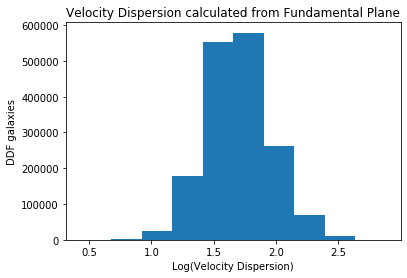

In [12]:
plt.hist(np.log10(sigma_fp))
plt.xlabel('Log(Velocity Dispersion)')
plt.ylabel('DDF galaxies')
plt.title('Velocity Dispersion calculated from Fundamental Plane')

## AGN Systems: Match to OM10

In [3]:
## Load OM10
hdulist = fits.open('../../../data/om10_qso_mock.fits')

In [4]:
om10_data = hdulist[1].data

In [6]:
# Only keep om10 systems where the host galaxy is within the redshift range of cosmoDC2
om10_data = om10_data[np.where(om10_data['ZSRC'] <= 3.0)]

In [92]:
def match_to_lenscat(vel_disp, redshift, om10_array, density=1.0):
    
    """
    Match DC2 galaxies to lens galaxies in OM10 based upon velocity dispersion and redshift.
    We set the threshold for a match to be 0.03 in dex in each parameter.
    
    Parameters
    ----------
    
    vel_disp: numpy.ndarray
      Velocity dispersion (km/s) values for each cosmoDC2 galaxy that is a potential lens galaxy
      
    redshift: numpy.ndarray
      Redshifts of potential lens galaxies from cosmoDC2
      
    om10_array: FITS recarray
      OM10 Lens Catalog
      
    Returns
    -------
    
    om10_idx: List of ints
        Indices of matches in OM10 catalog from input `om10_array`
        
    lens_gal_idx: List of ints
        Indices of corresponding cosmoDC2 galaxies from catalog that provided input `vel_disp` and `redshift`
        
    om10_lens_ids: List of ints
        OM10 LENSID values for systems matched is corresponding order as other outputs
    """
        
    lens_gal_idx = []
    om10_idx = []
    
    i = 0
    successful_matches = 0
    
    for row in om10_array:

        rand_state = np.random.RandomState(row['LENSID'])
        
        if i % 500 == 0:
            print("Matched %i out of %i possible OM10 systems so far. Total Catalog Length: %i" % 
                  (successful_matches, i, len(om10_array)))
        i += 1

        lens_z = row['ZLENS']
        log_lens_z = np.log10(lens_z)
        
        lens_sigma = row['VELDISP']
        log_lens_sigma = np.log10(lens_sigma)
        
        match_prob = rand_state.uniform()
        if lens_z < 0.8:
            match_prob *= 0.35
        if ((match_prob > density*.25) & (lens_sigma <= 225.)):
            continue
        elif ((match_prob > density) & (lens_sigma > 225.)):
            continue
        
        match_idx = (np.where((np.abs(log_lens_sigma - np.log10(vel_disp)) < 0.03) & 
                              (np.abs(log_lens_z - np.log10(redshift)) < 0.03)))[0]
        # Avoid duplicates
        match_idx_keep = [w for w in match_idx if w not in lens_gal_idx]
        if len(match_idx_keep) == 0:
            continue
        # Randomly choose one of the matches
        matched_lens_idx = rand_state.choice(match_idx_keep)

        lens_gal_idx.append(matched_lens_idx)
        om10_idx.append(i-1)
        successful_matches += 1
    
    om10_lens_ids = om10_array['LENSID'][om10_idx]

    return om10_idx, lens_gal_idx, om10_lens_ids

In [93]:
om10_match_idx, lens_gal_match_idx, om10_lensid = match_to_lenscat(sigma_fp, 
                                                                   full_lens_join['redshift_true'], 
                                                                   om10_data, density=0.2, seed=32)

Matched 0 out of 0 possible OM10 systems so far. Total Catalog Length: 11387
Matched 109 out of 500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 194 out of 1000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 270 out of 1500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 336 out of 2000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 387 out of 2500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 442 out of 3000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 484 out of 3500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 542 out of 4000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 598 out of 4500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 651 out of 5000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 698 out of 5500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 724 out of 600

Text(0.5, 1.0, 'Matched OM10 systems')

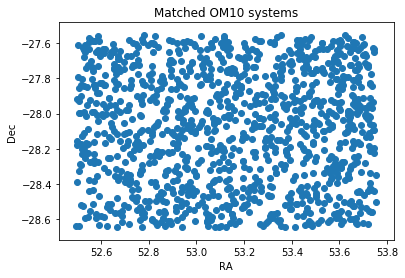

In [94]:
plt.scatter(full_lens_join['ra'][lens_gal_match_idx],
            full_lens_join['dec'][lens_gal_match_idx])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Matched OM10 systems')

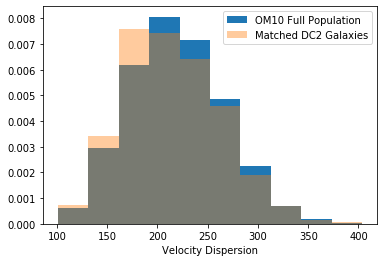

In [95]:
n, bins, _ = plt.hist(om10_data['VELDISP'], density=True, label='OM10 Full Population')
plt.hist(sigma_fp[lens_gal_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Velocity Dispersion')
plt.legend()

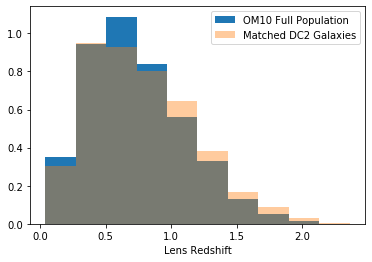

In [96]:
n, bins, _ = plt.hist(om10_data['ZLENS'], density=True, label='OM10 Full Population')
plt.hist(full_lens_join['redshift_true'][lens_gal_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Lens Redshift')
plt.legend()

In [97]:
agn_matched_ddf_lenses = full_lens_join.iloc[lens_gal_match_idx].reset_index(drop=True)

In [98]:
om10_data['LENSID'][om10_match_idx]

array([  270642,   431864,   630751, ..., 58984048, 60388311, 80722043],
      dtype=int32)

In [99]:
agn_matched_ddf_lenses['LENSID'] = np.array(om10_data['LENSID'][om10_match_idx], dtype=np.int)

In [100]:
agn_matched_ddf_lenses.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift,av_mw,rv_mw,fp_vel_disp,LENSID
0,2.177218,1.886121,3.460618,-0.001040,1.179262e+11,17.512337,1.0,-20.286049,-0.000449,2.170098,...,20.542064,20.591897,20.623454,20.638096,20.631165,0.181095,0.026148,3.1,190.502716,270642
1,0.735334,0.722462,1.097505,-0.001036,6.820154e+10,18.337564,1.0,-19.422682,-0.001793,0.968749,...,23.221701,23.175218,23.190502,23.219052,23.209327,0.187570,0.028221,3.1,200.800399,431864
2,1.068410,0.739304,1.229007,-0.001003,1.683040e+11,17.794094,1.0,-20.692518,0.002636,0.604274,...,38.210974,38.198500,38.179393,38.148983,38.169823,0.243461,0.020427,3.1,289.691799,630751
3,1.236465,1.144958,1.459931,0.001608,2.740304e+11,17.752117,1.0,-20.636387,-0.000557,1.214105,...,23.478229,23.506520,23.534547,23.553378,23.552282,0.238525,0.022437,3.1,273.597125,712582
4,0.911710,0.775163,1.494202,-0.000433,5.877293e+10,18.792974,1.0,-19.750357,0.000045,0.943332,...,26.490885,26.499475,26.492205,26.491227,26.489297,0.234548,0.029065,3.1,179.439468,795168


In [101]:
agn_matched_ddf_lenses.iloc[0]

morphology/spheroidHalfLightRadiusArcsec                                 2.17722
size_minor_bulge_true                                                    1.88612
size_disk_true                                                           3.46062
convergence                                                          -0.00103999
stellar_mass_bulge                                                   1.17926e+11
mag_true_r_lsst                                                          17.5123
sersic_disk                                                                    1
Mag_true_u_lsst_z0                                                       -20.286
shear_1                                                             -0.000449282
size_minor_disk_true                                                      2.1701
shear_2_phosim                                                        0.00203235
Mag_true_r_lsst_z0                                                      -22.4024
totalStarFormationRate      

In [102]:
print(om10_data[10]['ZLENS'], om10_data[10]['VELDISP'], 
      np.log10(om10_data[10]['ZLENS']), np.log10(om10_data[10]['VELDISP']),
      np.log10(agn_matched_ddf_lenses['redshift_true'].iloc[0]),
      np.log10(agn_matched_ddf_lenses['fp_vel_disp'].iloc[0]))

0.17 198.1527 -0.7695510786217261 2.296999994344255 -0.7453170710488755 2.279901171941923


In [5]:
## To save
# agn_matched_ddf_lenses.to_csv('agn_matched_ddf_lenses.csv', index=False)

## To load
# agn_matched_ddf_lenses = pd.read_csv('agn_matched_ddf_lenses.csv')

## SNe Systems: Match to Goldstein et al. 2018

## Find host galaxies for the matched systems

Here we take the OM10 systems that matched to DDF cosmoDC2 lens galaxies will use our cache of AGN hosting cosmoDC2 galaxies and find matches for the host galaxies in the OM10 systems and assign them to be sprinkled into the DDF field.

In [104]:
# Use only the OM10 systems that matched to DDF lens galaxies
om10_ddf_systems = om10_data[om10_match_idx]

In [106]:
def match_hosts_om10(redshift, agn_i_mag, om10_systems, seed=None):
    
    """
    Match host galaxies to OM10 systems based upon redshift and i-band AGN magnitude.
    """
    
    i = 0
    om10_idx = []
    host_gal_idx = []
    
    if seed is None:
        rand_state = np.random.RandomState()
    else:
        rand_state = np.random.RandomState(seed)
    
    for om10_row in om10_systems:
        log_z_om10 = np.log10(om10_row['ZSRC'])
        imag_om10 = om10_row['MAGI_IN']
        
        matches = np.where((np.abs(np.log10(redshift) - log_z_om10) < 0.03) &
                           (np.abs(agn_i_mag - imag_om10) < 0.05))[0]
        keep_matches = [w for w in matches if w not in host_gal_idx]
        if len(keep_matches) > 0:
            gal_match = rand_state.choice(keep_matches)
            om10_idx.append(i)
            host_gal_idx.append(gal_match)
            
        i += 1
        
    return om10_idx, host_gal_idx, om10_systems['LENSID'][om10_idx]

In [107]:
om10_index, agn_host_gal_index, om10_matched_lensid = match_hosts_om10(full_agn_host_join['redshift_true'],
                                                                       full_agn_host_join['mag_i_agn'],
                                                                       om10_ddf_systems, seed=274)

In [108]:
len(om10_index), len(om10_ddf_systems)

(1007, 1200)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text yticklabel objects>)

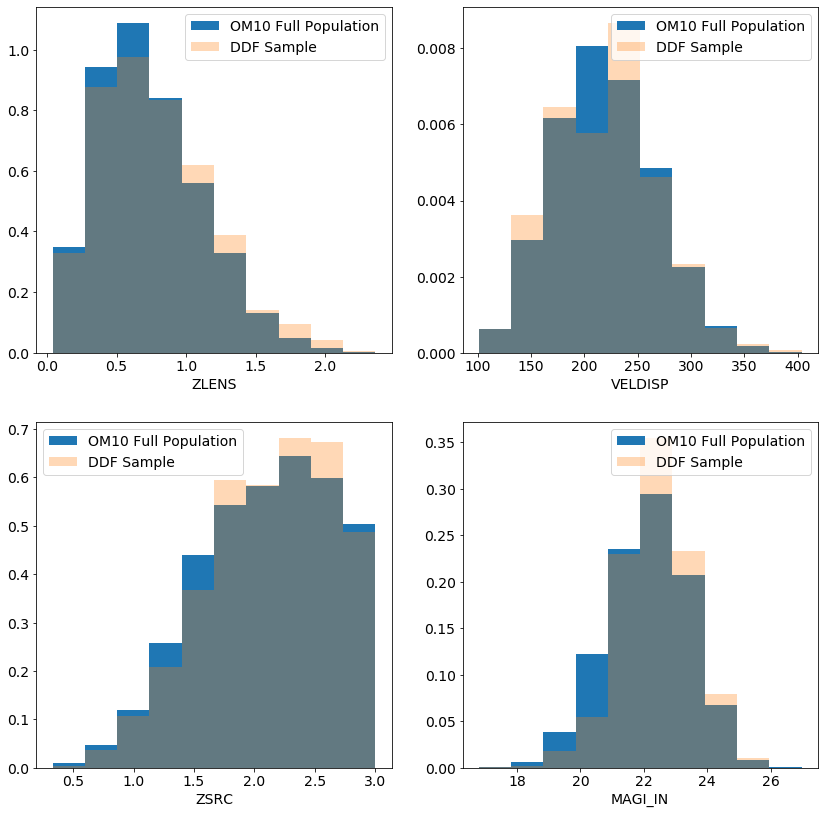

In [109]:
fig = plt.figure(figsize=(14, 14))
fig.add_subplot(2,2,1)
om10_key = 'ZLENS'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,2)
om10_key = 'VELDISP'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,3)
om10_key = 'ZSRC'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,4)
om10_key = 'MAGI_IN'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

In [110]:
agn_final_ddf_lenses = agn_matched_ddf_lenses.iloc[om10_index]

In [111]:
agn_final_ddf_lenses.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift,av_mw,rv_mw,fp_vel_disp,LENSID
1,0.735334,0.722462,1.097505,-0.001036,6.820154e+10,18.337564,1.0,-19.422682,-0.001793,0.968749,...,23.221701,23.175218,23.190502,23.219052,23.209327,0.187570,0.028221,3.1,200.800399,431864
2,1.068410,0.739304,1.229007,-0.001003,1.683040e+11,17.794094,1.0,-20.692518,0.002636,0.604274,...,38.210974,38.198500,38.179393,38.148983,38.169823,0.243461,0.020427,3.1,289.691799,630751
3,1.236465,1.144958,1.459931,0.001608,2.740304e+11,17.752117,1.0,-20.636387,-0.000557,1.214105,...,23.478229,23.506520,23.534547,23.553378,23.552282,0.238525,0.022437,3.1,273.597125,712582
4,0.911710,0.775163,1.494202,-0.000433,5.877293e+10,18.792974,1.0,-19.750357,0.000045,0.943332,...,26.490885,26.499475,26.492205,26.491227,26.489297,0.234548,0.029065,3.1,179.439468,795168
5,0.690444,0.666208,0.942147,0.001495,6.590908e+10,18.679579,1.0,-19.927004,-0.000065,0.774948,...,23.525968,23.579491,23.626799,23.662313,23.664341,0.248641,0.024709,3.1,225.600996,817516


In [127]:
agn_final_ddf_hosts = full_agn_host_join.iloc[agn_host_gal_index].reset_index(drop=True)

In [128]:
agn_final_ddf_hosts['LENSID'] = np.array(om10_matched_lensid, dtype=np.int)

In [129]:
agn_final_ddf_hosts.head()

,morphology/spheroidHalfLightRadiusArcsec,size_minor_bulge_true,size_disk_true,convergence,stellar_mass_bulge,mag_true_r_lsst,sersic_disk,Mag_true_u_lsst_z0,shear_1,size_minor_disk_true,...,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed,LENSID
0,0.271044,0.231076,0.455032,-0.011415,3.132704e+10,24.568460,1.0,-20.882278,0.028548,0.271882,...,24.597436,24.585081,52.333423,52.203738,52.182285,52.168953,52.158760,52.155844,2.200694,431864
1,0.154903,0.087732,0.218164,-0.029726,2.689564e+10,25.170961,1.0,-21.005508,0.025852,0.109613,...,25.024059,24.974204,45.235674,45.164242,45.126168,45.110305,45.102323,45.090587,2.484734,630751
2,0.566089,0.535162,0.720159,0.003365,2.314504e+11,22.709543,1.0,-22.227943,-0.021121,0.658783,...,22.242613,22.204858,46.119410,46.096360,46.079797,46.068980,46.115999,46.108321,1.567133,712582
3,0.266919,0.211657,0.336565,-0.012877,6.515574e+10,21.979477,1.0,-22.051477,-0.000901,0.171874,...,22.347394,22.409838,50.853262,50.833774,50.828189,50.871025,50.803683,50.924420,1.306357,795168
4,0.301768,0.245101,0.529270,-0.019677,2.146981e+10,22.781067,1.0,-21.145687,0.001588,0.161633,...,22.803761,22.812242,29.710731,29.765681,29.755978,29.731736,29.777994,29.820527,1.135262,817516


In [116]:
om10_ddf_final = om10_ddf_systems[om10_index]

In [5]:
## To save:
# agn_final_ddf_hosts.to_csv('%s/agn_final_ddf_hosts.csv' % os.environ['SCRATCH'], index=False)
# agn_final_ddf_lenses.to_csv('%s/agn_final_ddf_lenses.csv' % os.environ['SCRATCH'], index=False)

## To load:
# agn_final_ddf_hosts = pd.read_csv('%s/agn_final_ddf_hosts.csv' % os.environ['SCRATCH'])
# agn_final_ddf_lenses = pd.read_csv('%s/agn_final_ddf_lenses.csv' % os.environ['SCRATCH'])

In [117]:
om10_final_tbhdu = fits.BinTableHDU(om10_ddf_final)

In [14]:
## To save:
# om10_final_tbhdu.writeto('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])

## To load:
# om10_final_tbhdu = fits.open('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])

## Create truth catalogs

Here we create separate truth catalogs for the lenses, lensed hosts and lensed AGN. For the lenses, the photometry information is left out since it should be in the full WFD truth catalogs. To match up all the truth catalogs we can use `dc2_sys_id` to cross reference.

In [165]:
def create_lens_truth_dataframe(matched_lenses, matched_sys_cat, id_offset=0):

    new_entries = []

    for i in range(len(matched_sys_cat)):

        gal_id = matched_lenses.iloc[i]['galaxy_id']
        new_sys_id_num = i + id_offset
        new_sys_id = 'lensed_agn_%i' % new_sys_id_num
        # The newly inserted lens galaxy keeps the old gal_id
        unique_id = gal_id

        ra_lens = matched_lenses.iloc[i]['ra']
        dec_lens = matched_lenses.iloc[i]['dec']

        redshift = matched_sys_cat.iloc[i]['z_lens']
        shear_1_dc2 = matched_lenses.iloc[i]['gamma_1']
        shear_2_dc2 = matched_lenses.iloc[i]['gamma_2']
        kappa_dc2 = matched_lenses.iloc[i]['kappa']
        gamma_lenscat = matched_sys_cat.iloc[i]['gamma']
        phi_gamma_lenscat = matched_sys_cat.iloc[i]['phi_gamma']
        shear_1_lenscat = gamma_lenscat * np.cos(2 * phi_gamma_lenscat)
        shear_2_lenscat = gamma_lenscat * np.sin(2 * phi_gamma_lenscat)
        sindex_lens = 4

#         major_axis_lens = matched_sys_cat.iloc[i]['reff_lens'] / \
#                             np.sqrt(1 - matched_sys_cat.iloc[i]['ellip_lens'])
#         minor_axis_lens = matched_sys_cat.iloc[i]['reff_lens'] * \
#                             np.sqrt(1 - matched_sys_cat.iloc[i]['ellip_lens'])
#         position_angle = matched_sys_cat.iloc[i]['phie_lens']*(-1.0)*np.pi/180.0
        major_axis_lens = matched_lenses.iloc[i]['size']
        minor_axis_lens = matched_lenses.iloc[i]['size_minor']
        position_angle = matched_lenses.iloc[i]['position_angle']

        # Change dc2 ellip [(1-q)/(1+q)] to om10 ellipticity which is (1-q)
        q = minor_axis_lens/major_axis_lens
        ellip_lens = matched_lenses.iloc[i]['ellipticity'] * (1+q)
        # Just undoing what sprinkler did before
        # Need to check that this is correct still
        phie_lens = (-1.*position_angle)*(180./np.pi)

        av_mw = matched_lenses.iloc[i]['av_mw']
        rv_mw = matched_lenses.iloc[i]['rv_mw']

        vel_disp_lens = matched_lenses.iloc[i]['fp_vel_disp']

        cat_sys_id = matched_sys_cat.iloc[i]['system_id']

        new_row = [unique_id, ra_lens, dec_lens,
                   redshift, shear_1_dc2, shear_2_dc2, kappa_dc2, 
                   gamma_lenscat, phi_gamma_lenscat, 
                   shear_1_lenscat, shear_2_lenscat, sindex_lens,
                   major_axis_lens, minor_axis_lens,
                   position_angle, ellip_lens, phie_lens, 
                   av_mw, rv_mw, vel_disp_lens,
                   gal_id, cat_sys_id, new_sys_id]

        new_entries.append(new_row)

    lens_df = pd.DataFrame(new_entries, 
                           columns=['unique_id', 'ra_lens', 'dec_lens',
                                    'redshift', 'shear_1_cosmodc2', 'shear_2_cosmodc2',
                                    'kappa_cosmodc2', 'gamma_lenscat', 'phig_lenscat',
                                    'shear_1_lenscat', 'shear_2_lenscat',
                                    'sindex_lens', 'major_axis_lens',
                                    'minor_axis_lens', 'position_angle', 'ellip',
                                    'phie', 'av_mw', 'rv_mw',
                                    'vel_disp_lenscat', 'original_gal_id', 
                                    'lens_cat_sys_id', 'dc2_sys_id'])

    return lens_df

In [17]:
import sys
sys.path.append('../../../sprinkler/')
%load_ext autoreload
%autoreload 2

In [18]:
from lens_catalog_readers import OM10Reader

In [19]:
om10_ddf_fits = OM10Reader('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])
om10_ddf_sprinkler_cat = pd.DataFrame(om10_ddf_fits.load_catalog())

In [10]:
agn_final_ddf_lenses = agn_final_ddf_lenses.rename(columns={'shear_1': 'gamma_1', 
                                                            'shear_2_phosim':'gamma_2',
                                                            'size':'size_true',
                                                            'size_minor':'size_minor_true',
                                                            'convergence':'kappa',
                                                            'position_angle_true':'position_angle',})

In [ ]:
lens_df_truth = create_lens_truth_dataframe(agn_final_ddf_lenses, om10_ddf_sprinkler_cat)

In [170]:
lens_df_truth.head()

,unique_id,ra_lens,dec_lens,redshift,shear_1_cosmodc2,shear_2_cosmodc2,kappa_cosmodc2,gamma_lenscat,phig_lenscat,shear_1_lenscat,...,minor_axis_lens,position_angle,ellip_lenscat,phie_lenscat,av_mw,rv_mw,vel_disp_lenscat,original_gal_id,lens_cat_sys_id,dc2_sys_id
0,2562528262,52.590129,-28.471658,0.200,-0.001793,0.002106,-0.001036,0.051598,75.38537,0.051581,...,0.0,0.683450,0.278412,-39.15880,0.028221,3.1,200.800399,2562528262,431864,lensed_agn_0
1,2562564013,53.442078,-28.469428,0.228,0.002636,0.003578,-0.001003,0.070167,-137.06410,-0.048398,...,0.0,-2.731583,0.104775,156.50820,0.020427,3.1,289.691799,2562564013,630751,lensed_agn_1
2,2562542568,53.151976,-28.193926,0.238,-0.000557,0.001082,0.001608,0.034721,62.90516,0.034348,...,0.0,3.123481,0.175851,-178.96230,0.022437,3.1,273.597125,2562542568,712582,lensed_agn_2
3,2562541324,53.557830,-28.256308,0.248,0.000045,0.000245,-0.000433,0.055342,158.11420,-0.026452,...,0.0,-0.800034,0.185953,45.83859,0.029065,3.1,179.439468,2562541324,795168,lensed_agn_3
4,1875062778,52.704802,-27.980146,0.250,-0.000065,0.001144,0.001495,0.058938,48.87865,-0.054994,...,0.0,-1.241586,0.177506,71.13763,0.024709,3.1,225.600996,1875062778,817516,lensed_agn_4


In [188]:
lens_df_truth.columns

Index(['unique_id', 'ra_lens', 'dec_lens', 'redshift', 'shear_1_cosmodc2',
       'shear_2_cosmodc2', 'kappa_cosmodc2', 'gamma_lenscat', 'phig_lenscat',
       'shear_1_lenscat', 'shear_2_lenscat', 'sindex_lens', 'major_axis_lens',
       'minor_axis_lens', 'position_angle', 'ellip_lenscat', 'phie_lenscat',
       'av_mw', 'rv_mw', 'vel_disp_lenscat', 'original_gal_id',
       'lens_cat_sys_id', 'dc2_sys_id'],
      dtype='object')

In [189]:
lens_df_truth.to_csv('lens_df_truth.csv', index=False)

In [12]:
def merge_labelled_columns(df_merged, label):

    labelled_columns = ['%s_u' %label,
                        '%s_g' %label,
                        '%s_r' %label,
                        '%s_i' %label,
                        '%s_z' %label,
                        '%s_y' %label]

    label_array = df_merged[labelled_columns].values

    return label_array

In [180]:
def create_host_truth_dataframe(matched_lenses, matched_hosts, matched_sys_cat,
                                id_offset=0):

    new_entries = []

    for i in range(len(matched_sys_cat)):
        for j in range(matched_sys_cat.iloc[i]['n_img']):

            gal_id = matched_hosts.iloc[i]['galaxy_id']+j
            new_sys_id_num = i + id_offset
            new_sys_id = 'lensed_agn_%i' % new_sys_id_num
            image_number = j
            unique_id = 'agn_host_%i_%i' % (new_sys_id_num, image_number)

            ra_lens = matched_lenses.iloc[i]['ra']
            dec_lens = matched_lenses.iloc[i]['dec']

            x_src = matched_sys_cat.iloc[i]['x_src']
            y_src = matched_sys_cat.iloc[i]['y_src']
            x_img = matched_sys_cat.iloc[i]['x_img'][j]
            y_img = matched_sys_cat.iloc[i]['y_img'][j]

            delta_ra = np.radians(matched_sys_cat.iloc[i]['x_img'][j] / 3600.0)
            delta_dec = np.radians(matched_sys_cat.iloc[i]['y_img'][j] / 3600.0)
            ra_host = ra_lens + delta_ra/np.cos(dec_lens)
            dec_host = dec_lens + delta_dec

            mag_adjust = 2.5*np.log10(np.abs(matched_sys_cat.iloc[i]['magnification_img'][j]))
            magnorm_disk_array = merge_labelled_columns(matched_hosts.iloc[i], 'disk_magnorm')
            magnorm_disk = magnorm_disk_array - mag_adjust
            magnorm_disk_u = magnorm_disk[0]
            magnorm_disk_g = magnorm_disk[1]
            magnorm_disk_r = magnorm_disk[2]
            magnorm_disk_i = magnorm_disk[3]
            magnorm_disk_z = magnorm_disk[4]
            magnorm_disk_y = magnorm_disk[5]
            magnorm_bulge_array = merge_labelled_columns(matched_hosts.iloc[i], 'bulge_magnorm')
            magnorm_bulge = magnorm_bulge_array - mag_adjust
            magnorm_bulge_u = magnorm_bulge[0]
            magnorm_bulge_g = magnorm_bulge[1]
            magnorm_bulge_r = magnorm_bulge[2]
            magnorm_bulge_i = magnorm_bulge[3]
            magnorm_bulge_z = magnorm_bulge[4]
            magnorm_bulge_y = magnorm_bulge[5]
            redshift = matched_sys_cat.iloc[i]['z_src']
            shear_1 = 0. #matched_hosts.iloc[i]['gamma_1']
            shear_2 = 0. #matched_hosts.iloc[i]['gamma_2']
            kappa = 0. #matched_hosts.iloc[i]['kappa']
            sindex_bulge = 4
            sindex_disk = 1

            major_axis_disk = matched_hosts.iloc[i]['semi_major_axis_disk']
            major_axis_bulge = matched_hosts.iloc[i]['semi_major_axis_bulge']
            minor_axis_disk = matched_hosts.iloc[i]['semi_minor_axis_disk']
            minor_axis_bulge = matched_hosts.iloc[i]['semi_minor_axis_bulge']
            position_angle = matched_hosts.iloc[i]['position_angle']

            av_internal_disk = matched_hosts.iloc[i]['av_internal_disk']
            av_internal_bulge = matched_hosts.iloc[i]['av_internal_bulge']
            rv_internal_disk = matched_hosts.iloc[i]['rv_internal_disk']
            rv_internal_bulge = matched_hosts.iloc[i]['rv_internal_bulge']
            av_mw = matched_lenses.iloc[i]['av_mw']
            rv_mw = matched_lenses.iloc[i]['rv_mw']

            sed_disk_host = matched_hosts.iloc[i]['sed_disk']
            sed_bulge_host = matched_hosts.iloc[i]['sed_bulge']

            cat_sys_id = matched_sys_cat.iloc[i]['system_id']

            new_row = [unique_id, x_src, y_src, x_img, y_img,
                       ra_lens, dec_lens, ra_host, dec_host,
                       magnorm_disk_u, magnorm_disk_g, magnorm_disk_r,
                       magnorm_disk_i, magnorm_disk_z, magnorm_disk_y,
                       magnorm_bulge_u, magnorm_bulge_g, magnorm_bulge_r,
                       magnorm_bulge_i, magnorm_bulge_z, magnorm_bulge_y,
                       redshift, shear_1, shear_2, kappa, sindex_bulge, sindex_disk,
                       major_axis_disk, major_axis_bulge, minor_axis_disk, minor_axis_bulge,
                       position_angle, av_internal_disk, av_internal_bulge, rv_internal_disk,
                       rv_internal_bulge, av_mw, rv_mw, sed_disk_host, sed_bulge_host,
                       gal_id, cat_sys_id, new_sys_id, image_number]

            new_entries.append(new_row)

    host_df = pd.DataFrame(new_entries, 
                           columns=['unique_id', 'x_src', 'y_src', 'x_img', 'y_img',
                                    'ra_lens', 'dec_lens', 'ra_host', 'dec_host',
                                    'magnorm_disk_u', 'magnorm_disk_g', 'magnorm_disk_r',
                                    'magnorm_disk_i', 'magnorm_disk_z', 'magnorm_disk_y',
                                    'magnorm_bulge_u', 'magnorm_bulge_g', 'magnorm_bulge_r',
                                    'magnorm_bulge_i', 'magnorm_bulge_z', 'magnorm_bulge_y',
                                    'redshift', 'shear_1', 'shear_2',
                                    'kappa', 'sindex_bulge', 'sindex_disk',
                                    'major_axis_disk', 'major_axis_bulge', 'minor_axis_disk',
                                    'minor_axis_bulge', 'position_angle',
                                    'av_internal_disk', 'av_internal_bulge',
                                    'rv_internal_disk', 'rv_internal_bulge',
                                    'av_mw', 'rv_mw', 'sed_disk_host',
                                    'sed_bulge_host', 'original_gal_id', 
                                    'lens_cat_sys_id', 'dc2_sys_id', 'image_number'])

    return host_df

In [181]:
agn_final_ddf_hosts = agn_final_ddf_hosts.rename(columns={'size_disk_true':'semi_major_axis_disk',
                                                          'size_bulge_true':'semi_major_axis_bulge',
                                                          'size_minor_disk_true':'semi_minor_axis_disk',
                                                          'size_minor_bulge_true':'semi_minor_axis_bulge',
                                                          'position_angle_true':'position_angle',
                                                          'disk_av':'av_internal_disk',
                                                          'disk_rv':'rv_internal_disk',
                                                          'bulge_av':'av_internal_bulge',
                                                          'bulge_rv':'rv_internal_bulge',
                                                          'disk_sed':'sed_disk',
                                                          'bulge_sed':'sed_bulge'})

In [182]:
host_df_truth = create_host_truth_dataframe(agn_final_ddf_lenses, agn_final_ddf_hosts, om10_ddf_sprinkler_cat)

In [183]:
host_df_truth.head()

,unique_id,x_src,y_src,x_img,y_img,ra_lens,dec_lens,ra_host,dec_host,magnorm_disk_u,...,rv_internal_disk,rv_internal_bulge,av_mw,rv_mw,sed_disk_host,sed_bulge_host,original_gal_id,lens_cat_sys_id,dc2_sys_id,image_number
0,agn_host_0_0,0.117692,-0.068496,0.8468,-0.8346,52.590129,-28.471658,52.590125,-28.471662,50.750636,...,2.0,2.0,0.028221,3.1,b'galaxySED/Inst.15E07.002Z.spec.gz',b'galaxySED/Exp.20E09.1Z.spec.gz',12076730921,431864,lensed_agn_0,0
1,agn_host_0_1,0.117692,-0.068496,-0.8855,-0.0972,52.590129,-28.471658,52.590134,-28.471658,50.516646,...,2.0,2.0,0.028221,3.1,b'galaxySED/Inst.15E07.002Z.spec.gz',b'galaxySED/Exp.20E09.1Z.spec.gz',12076730922,431864,lensed_agn_0,1
2,agn_host_1_0,0.022639,-0.263653,-0.3589,1.6666,53.442078,-28.469428,53.442080,-28.469420,43.767772,...,2.0,4.0,0.020427,3.1,b'galaxySED/Inst.15E07.002Z.spec.gz',b'galaxySED/Burst.10E09.04Z.spec.gz',11454174276,630751,lensed_agn_1,0
3,agn_host_1_1,0.022639,-0.263653,-0.8938,-2.1632,53.442078,-28.469428,53.442083,-28.469439,42.907703,...,2.0,4.0,0.020427,3.1,b'galaxySED/Inst.15E07.002Z.spec.gz',b'galaxySED/Burst.10E09.04Z.spec.gz',11454174277,630751,lensed_agn_1,1
4,agn_host_2_0,1.328972,-0.005959,3.2168,0.1990,53.151976,-28.193926,53.151960,-28.193925,45.266565,...,2.0,2.0,0.022437,3.1,b'galaxySED/Inst.32E07.002Z.spec.gz',b'galaxySED/Exp.25E09.1Z.spec.gz',11443429798,712582,lensed_agn_2,0


In [34]:
# Show that pandas abbreviates and full float64 values are still in dataframe
host_df_truth.iloc[0]['ra_host'], host_df_truth.iloc[0]['ra_lens']

(52.590125046127575, 52.59012923277288)

In [35]:
host_df_truth.iloc[0]['dec_host'], host_df_truth.iloc[0]['dec_lens']

(-28.471661879449467, -28.471657833194488)

In [193]:
host_df_truth.columns

Index(['unique_id', 'x_src', 'y_src', 'x_img', 'y_img', 'ra_lens', 'dec_lens',
       'ra_host', 'dec_host', 'magnorm_disk_u', 'magnorm_disk_g',
       'magnorm_disk_r', 'magnorm_disk_i', 'magnorm_disk_z', 'magnorm_disk_y',
       'magnorm_bulge_u', 'magnorm_bulge_g', 'magnorm_bulge_r',
       'magnorm_bulge_i', 'magnorm_bulge_z', 'magnorm_bulge_y', 'redshift',
       'shear_1', 'shear_2', 'kappa', 'sindex_bulge', 'sindex_disk',
       'major_axis_disk', 'major_axis_bulge', 'minor_axis_disk',
       'minor_axis_bulge', 'position_angle', 'av_internal_disk',
       'av_internal_bulge', 'rv_internal_disk', 'rv_internal_bulge', 'av_mw',
       'rv_mw', 'sed_disk_host', 'sed_bulge_host', 'original_gal_id',
       'lens_cat_sys_id', 'dc2_sys_id', 'image_number'],
      dtype='object')

In [190]:
host_df_truth.to_csv('host_df_truth.csv', index=False)

#### Write dataframes to sqlite files

In [22]:
engine = create_engine('sqlite:///%s' % 'host_df_truth.db', echo=False)
host_df_truth.to_sql('agn_hosts', con=engine)

In [23]:
engine = create_engine('sqlite:///%s' % 'lens_df_truth.db', echo=False)
lens_df_truth.to_sql('agn_lens', con=engine)

In [18]:
import json

def output_lensed_agn_truth(matched_hosts, matched_lenses,
                            matched_sys_cat, out_file,
                            return_df=True, id_offset=0):

    new_entries = []

    for i in range(len(matched_sys_cat)):
        for j in range(matched_sys_cat.iloc[i]['n_img']):

            gal_id = matched_hosts.iloc[i]['galaxy_id']+j
            new_sys_id_num = i + id_offset
            new_sys_id = 'lensed_agn_%i' % new_sys_id_num
            image_number = j
            gal_unique_id = 'agn_image_%i_%i' % (new_sys_id_num, image_number)

            ra_lens = matched_lenses.iloc[i]['ra']
            dec_lens = matched_lenses.iloc[i]['dec']
            delta_ra = np.radians(matched_sys_cat.iloc[i]['x_img'][j] / 3600.0)
            delta_dec = np.radians(matched_sys_cat.iloc[i]['y_img'][j] / 3600.0)
            ra = ra_lens + delta_ra/np.cos(dec_lens)
            dec = dec_lens + delta_dec

            redshift = matched_sys_cat.iloc[i]['z_src']
            t_delay = matched_sys_cat.iloc[i]['t_delay_img'][j]

            magnorm = matched_hosts.iloc[i]['magNorm_agn']
            mag = matched_sys_cat.iloc[i]['magnification_img'][j]

            agn_var_param = json.loads(matched_hosts.iloc[i]['varParamStr_agn'])['p']
            seed = agn_var_param['seed']
            agn_tau_u = agn_var_param['agn_tau_u']
            agn_tau_g = agn_var_param['agn_tau_g']
            agn_tau_r = agn_var_param['agn_tau_r']
            agn_tau_i = agn_var_param['agn_tau_i']
            agn_tau_z = agn_var_param['agn_tau_z']
            agn_tau_y = agn_var_param['agn_tau_y']
            agn_sf_u = agn_var_param['agn_sf_u']
            agn_sf_g = agn_var_param['agn_sf_g']
            agn_sf_r = agn_var_param['agn_sf_r']
            agn_sf_i = agn_var_param['agn_sf_i']
            agn_sf_z = agn_var_param['agn_sf_z']
            agn_sf_y = agn_var_param['agn_sf_y']

            av_mw = matched_lenses.iloc[i]['av_mw']
            rv_mw = matched_lenses.iloc[i]['rv_mw']

            cat_sys_id = matched_sys_cat.iloc[i]['system_id']

            new_row = [gal_unique_id, gal_unique_id, ra, dec, 
                       redshift, t_delay, magnorm, mag, 
                       seed, agn_tau_u, agn_tau_u, agn_tau_u,
                       agn_tau_u, agn_tau_u, agn_tau_u,
                       agn_sf_u, agn_sf_g, agn_sf_r, 
                       agn_sf_i, agn_sf_z, agn_sf_y, 
                       av_mw, rv_mw, new_sys_id,
                       cat_sys_id, image_number]

            new_entries.append(new_row)

    agn_df = pd.DataFrame(new_entries,
                          columns=['unique_id', 'gal_unq_id', 'ra', 'dec',
                                   'redshift', 't_delay', 'magnorm', 'magnification',
                                   'seed', 'agn_tau_u', 'agn_tau_g', 'agn_tau_r',
                                   'agn_tau_i', 'agn_tau_z', 'agn_tau_y',
                                   'agn_sf_u', 'agn_sf_g', 'agn_sf_r',
                                   'agn_sf_i', 'agn_sf_z', 'agn_sf_y', 
                                   'av_mw', 'rv_mw', 'dc2_sys_id',
                                   'lens_cat_sys_id', 'image_number'])

    engine = create_engine('sqlite:///%s' % out_file, echo=False)
    agn_df.to_sql('lensed_agn', con=engine)

    if return_df is True:
        return agn_df

In [21]:
lensed_agn_truth = output_lensed_agn_truth(agn_final_ddf_hosts, 
                                           agn_final_ddf_lenses,
                                           om10_ddf_sprinkler_cat, 'lensed_agn_truth.db', return_df=True)

In [17]:
lensed_agn_truth.head()

,unique_id,gal_unq_id,ra,dec,redshift,t_delay,magnorm,magnification,seed,agn_tau_u,...,agn_sf_g,agn_sf_r,agn_sf_i,agn_sf_z,agn_sf_y,av_mw,rv_mw,dc2_sys_id,lens_cat_sys_id,image_number
0,agn_image_0_0,agn_image_0_0,52.590125,-28.471662,2.16,0.000,25.050521,4.2965,5480703,310.6,...,0.7522,0.6653,0.6063,0.5665,0.5373,0.028221,3.1,lensed_agn_0,431864,0
1,agn_image_0_1,agn_image_0_1,52.590134,-28.471658,2.16,8.204,25.050521,-5.3298,5480703,310.6,...,0.7522,0.6653,0.6063,0.5665,0.5373,0.028221,3.1,lensed_agn_0,431864,1
2,agn_image_1_0,agn_image_1_0,53.442080,-28.469420,2.54,33.235,25.105411,-3.8651,9003371,132.9,...,0.5333,0.4715,0.4296,0.4012,0.3805,0.020427,3.1,lensed_agn_1,630751,0
3,agn_image_1_1,agn_image_1_1,53.442083,-28.469439,2.54,0.000,25.105411,8.5347,9003371,132.9,...,0.5333,0.4715,0.4296,0.4012,0.3805,0.020427,3.1,lensed_agn_1,630751,1
4,agn_image_2_0,agn_image_2_0,53.151960,-28.193925,1.51,0.000,23.105514,2.1935,5609004,378.7,...,0.5465,0.4830,0.4400,0.4110,0.3897,0.022437,3.1,lensed_agn_2,712582,0


In [194]:
lensed_agn_truth.columns

Index(['unique_id', 'gal_unq_id', 'ra', 'dec', 'redshift', 't_delay',
       'magnorm', 'magnification', 'seed', 'agn_tau_u', 'agn_tau_g',
       'agn_tau_r', 'agn_tau_i', 'agn_tau_z', 'agn_tau_y', 'agn_sf_u',
       'agn_sf_g', 'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y', 'av_mw',
       'rv_mw', 'dc2_sys_id', 'lens_cat_sys_id', 'image_number'],
      dtype='object')

In [192]:
lensed_agn_truth.to_csv('lensed_agn_df_truth.csv', index=False)

## Write out to sqlite files